In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from multihist import Histdd, Hist1d
import hax

/home/xedaq/anaconda3/envs/pax_jelle/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
hax.init(pax_version_policy='loose',
         raw_data_local_path='/data/xenon/raw')

In [5]:
# Get number of PMTs
from pax import configuration
pax_config = configuration.load_configuration('XENON1T')
n_channels = pax_config['DEFAULT']['n_channels']

In [3]:
# Get a recent background run
dsets = hax.runs.datasets
dsets = dsets[dsets['source__type'] == 'none']
dsets.iloc[-3].number

13781

In [4]:
run_id = 13781

In [82]:
# Hours needed per hour of data (1 CPU)
(18757 * 318/132)/3600

12.55203282828283

In [90]:
# Expected total waveforms extracted
n_wv_expected = 20000 * 18757/126

# MB RAM required
n_wv_expected, n_wv_expected * 4 * 61 / 1e6

(2977301.587301587, 726.4615873015872)

In [10]:
# Turn off debug messages (avoid giant dump when processing)
import logging
logging.basicConfig(level=logging.INFO)
logging.getLogger().setLevel(logging.INFO)

# Do extraction

In [ ]:
from pax.plugins.peak_processing.BasicProperties import put_w_in_center_of_field
from pax.dsputils import adc_to_pe

import collections
def unique_only(x):
    counts = collections.Counter(x)
    return np.array([q for q in x if counts[q] == 1])


save_before_and_after = 30

n_max_wvs = int(1e6)
n_samples = 2 * save_before_and_after + 1
waveforms = np.zeros((n_samples, n_max_wvs), dtype=np.int)
channels = []
wv_i = 0

for event in tqdm(hax.raw_data.process_events(
        run_id=run_id, 
        config_override=dict(#HitFinder=dict(height_over_noise_high_threshold=8),
                             pax=dict(compute_properties=[],
                                      pre_analysis=[],
                                      pre_output=[], 
                                      output=[],
                                      encoder_plugin=None)))):

    # Find pulses which can participate 
    pulse_indices = []
    for peak in event.peaks:
        if not peak.detector == 'tpc':
            continue
            
        # Have one and only one hit in a single electron
#        if not (12 <= peak.area < 45 
#                and 80 <= peak.range_area_decile[5] < 500 ):
#            continue
            
        if not peak.type == 'lone_hit':
            continue
        
        pulse_indices.append(peak.hits['found_in_pulse'])
        
    if not len(pulse_indices):
        continue
    pulse_indices = unique_only(np.concatenate(pulse_indices))

    # Save samples before and after the maximum
    for pulse_i in pulse_indices:
        p = event.pulses[pulse_i]
        w = p.raw_data
        w = np.mean(w[:40]) - w
        #w *= adc_to_pe(pax_config['DEFAULT'], ch)
        
        put_w_in_center_of_field(w, waveforms[:, wv_i], np.argmax(w))
        channels.append(p.channel)
        wv_i += 1
        
        if wv_i >= n_max_wvs:
            break

    # For breaking outer loop.. 
    if wv_i >= n_max_wvs:
        break

channels = np.array(channels)
waveforms = waveforms[:, :wv_i]


0it [00:00, ?it/s]INFO:processor] This is PAX version 6.8.1, running with configuration for XENON1T.

Exception in thread Thread-79:
Traceback (most recent call last):
  File "/home/xedaq/anaconda3/envs/pax_jelle/lib/python3.4/threading.py", line 911, in _bootstrap_inner
    self.run()
  File "/home/xedaq/anaconda3/envs/pax_jelle/lib/python3.4/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/home/xedaq/anaconda3/envs/pax_jelle/lib/python3.4/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

INFO:ReadZipped] InputFromFolder: Selecting file /data/xenon/raw/171018_0917/XENON1T-13781-000000000-000000099-000000100.zip (number 1/187 in folder) for reading
1it [00:12, 12.70s/it]

In [97]:
wv_i

1000000

In [ ]:
np.savez_compressed('spes_run%d_%d.npz' % (run_id, wv_i),
                    channels=channels,
                    waveforms=waveforms)

In [124]:
from scipy import stats

In [125]:
mean = waveforms.mean(axis=1)
sigma = (np.percentile(waveforms, stats.norm.cdf(1) * 100, axis=1) - 
          np.percentile(waveforms, stats.norm.cdf(-1) * 100, axis=1))/2
errors = sigma/np.sqrt(wv_i)

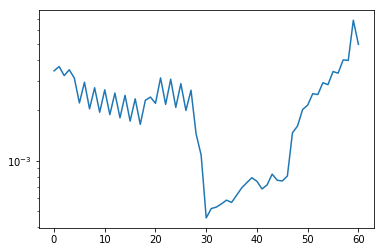

In [151]:
plt.plot(errors/mean)
plt.yscale('log')

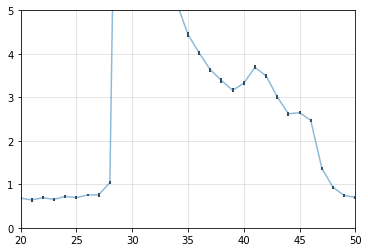

In [146]:
x = np.arange(len(mean))
#plt.plot(x, mean + errors)
#plt.plot(x, mean - errors)
#plt.plot(x, mean)
plt.plot(x, mean, alpha=0.5)
plt.errorbar(x,
             mean, 
             yerr=errors * 20,
             linestyle='', c='k',
             
             #elinewidth=10,
             #linestyle='steps-mid'
            )
plt.xlim(20, 50)
plt.ylim(0, 5)
#plt.ylim(-5, 5)
plt.grid(alpha=0.4)